## Pretraining BERT

In [3]:
import torch 
from torch import nn
from d2l import torch as d2l

batch_size, max_len = 1024, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

## A small BERT, using 2 layers, 128 hidden units, and 2 self-attention heads

In [4]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

##  Computes the loss for both the masked language modeling and next sentence prediction taks

In [5]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, 
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # (批量大小，最大序列长度，num_hiddens）, 预测位置的输出，是否是下一个句子的输出
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, 
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

## Pretrain BERT(```net```) on the WikiText-2(```train_iter```)dataset

In [6]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

## 训练！！

MLM loss 5.273, NSP loss 0.719
11943.0 sentence pairs/sec on [device(type='cuda', index=0)]


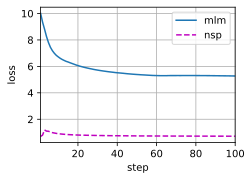

In [7]:
num_steps = 100
train_bert(train_iter, net, loss, len(vocab), devices, num_steps)

## Respresenting Text with BERT

In [8]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    # 使用BERT抽取特征
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    # (批量大小，最大序列长度，num_hiddens）
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

## Consider the sentence "a crane if flying"

In [9]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
# 第0个词 <cls>
encoded_text_cls = encoded_text[:, 0, :]
# 第2个词 "crane"
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-0.1625,  2.2925, -0.0618], device='cuda:0', grad_fn=<SliceBackward0>))

## 多个句子

In [10]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([0.0051, 0.7763, 0.5360], device='cuda:0', grad_fn=<SliceBackward0>))